**大型语言模型（LLMs）** 可以通过工具调用功能与外部数据源进行交互。工具调用是一种强大的技术，它允许开发者构建复杂的应用程序，利用LLMs访问、交互和处理数据库、文件和API等外部资源。

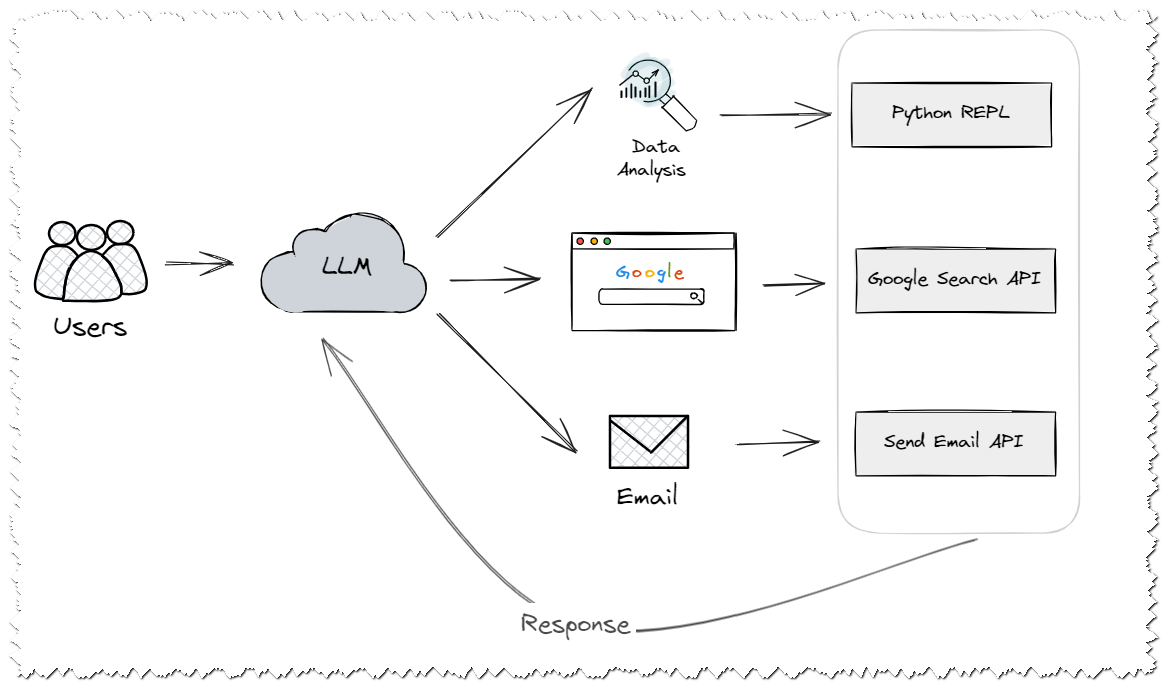


- 扩展语言模型的能力范围:
工具调用使大型语言模型能够与外部世界进行交互,极大地扩展了它们的能力范围。它们不再局限于基于预训练数据的文本生成,而是可以访问实时信息、执行计算、操作数据库等。

- 实现复杂任务自动化:
工具调用允许语言模型执行一系列复杂的操作,如查询数据库、调用API、执行计算等。这使得它们能够自动化许多原本需要人工干预的复杂任务流程。


|  Attribute   | Type |	Description  | 
|  ----  | ----  | ---- |
| name  | str |  Must be unique within a set of tools provided to an LLM or agent. |
| description  | str | Describes what the tool does. Used as context by the LLM or agent. |
| args_schema  | Pydantic BaseModel |  Optional but recommended, can be used to provide more information (e.g., few-shot examples) or validation for expected parameters |
| return_direct  | boolean |  Only relevant for agents. When True, after invoking the given tool, the agent will stop and return the result direcly to the user. |



各服务提供商已经在其模型中引入了本地工具调用功能。在实际应用中，当LLM为提示提供自动补全时，除了普通文本之外，还可以返回工具调用的列表。OpenAI大约一年前首次发布了“函数调用”，到11月已发展为“工具调用”。此后，其他模型提供商也纷纷效仿：Gemini（12月）、Mistral（2月）、Fireworks（3月）、Together（3月）、Groq（4月）、Cohere（4月）和Anthropic（4月）。


大型语言模型可以通过工具调用功能与外部数据源进行交互。工具调用是一种强大的技术,它允许开发者构建复杂的应用程序,利用大型语言模型来访问、交互和操作外部资源,如数据库、文件和API。
各大AI服务提供商已经开始在他们的模型中引入原生的工具调用能力。在实践中,这意味着当大型语言模型对提示(prompt)进行自动补全时,除了普通文本之外,还可以返回一系列工具调用。

为了让聊天模型能够使用工具，我们需要向模型提供一份可用工具的清单，以及这些工具的参数结构。不同的模型提供商可能要求不同的工具定义格式。例如，OpenAI需要的是一个包含“name”（名称）、“description”（描述）和“parameters”（参数）键的字典，而Anthropic则需要“name”（名称）、“description”（描述）和“input_schema”（输入架构）。

ChatModel.bind_tools方法提供了一个标准的接口，所有支持调用工具的模型都会实现这个接口。通过这个接口，你可以指定模型能够使用的工具。你可以传递一个工具的原始定义（一个字典），也可以传递可以从其中生成工具定义的其它对象，比如Pydantic类、LangChain工具或任意的函数。这样做使得创建通用的工具定义变得简单，这些定义可以与任意支持调用工具的模型一起使用。

In [1]:
from getpass import getpass
import os

DASHSCOPE_API_KEY = getpass()
os.environ["DASHSCOPE_API_KEY"] = DASHSCOPE_API_KEY

In [2]:
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.messages import HumanMessage, SystemMessage

chatLLM = ChatTongyi(
    streaming=False ,
)
messages = [
    SystemMessage(
        content="You are a helpful assistant that translates English to Chinese."
    ),
    HumanMessage(
        content="I love LLM."
    ),
]
chatLLM.invoke(messages)

AIMessage(content='我喜欢LLM。', response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': '8d993ca8-df9c-924e-9b2e-e58e5cefc5b0', 'token_usage': {'input_tokens': 29, 'output_tokens': 4, 'total_tokens': 33}}, id='run-393f371a-b80a-4a91-bd9b-ec704b313f83-0')

In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

# ✅ Pydantic class
class multiply(BaseModel):
    """Return product of 'x' and 'y'."""
    x: float = Field(..., description="First factor")
    y: float = Field(..., description="Second factor")
    
# ✅ LangChain tool
@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return x**y
    
# ✅ Function
def subtract(x: float, y: float) -> float:
    """Subtract 'x' from 'y'."""
    return y-x
    
# ✅ OpenAI-format dict
# Could also pass in a JSON schema with "title" and "description" 
add = {
  "name": "add",
  "description": "Add 'x' and 'y'.",
  "parameters": {
    "type": "object",
    "properties": {
      "x": {"type": "number", "description": "First number to add"},
      "y": {"type": "number", "description": "Second number to add"}
    },
    "required": ["x", "y"]
  }
}



In [17]:
subtract(x=5,y=2)

-3

In [18]:
multiply

__main__.multiply

In [4]:
# Whenever we invoke `llm_with_tool`, all three of these tool definitions
# are passed to the model.
llm_with_tools = chatLLM.bind_tools([multiply, exponentiate, add, subtract])

In [5]:
llm_with_tools.kwargs

{'tools': [{'type': 'function',
   'function': {'name': 'multiply',
    'description': "Return product of 'x' and 'y'.",
    'parameters': {'type': 'object',
     'properties': {'x': {'description': 'First factor', 'type': 'number'},
      'y': {'description': 'Second factor', 'type': 'number'}},
     'required': ['x', 'y']}}},
  {'type': 'function',
   'function': {'name': 'exponentiate',
    'description': "Raise 'x' to the 'y'.",
    'parameters': {'type': 'object',
     'properties': {'x': {'type': 'number'}, 'y': {'type': 'number'}},
     'required': ['x', 'y']}}},
  {'type': 'function',
   'function': {'name': 'add',
    'description': "Add 'x' and 'y'.",
    'parameters': {'type': 'object',
     'properties': {'x': {'type': 'number',
       'description': 'First number to add'},
      'y': {'type': 'number', 'description': 'Second number to add'}},
     'required': ['x', 'y']}}},
  {'type': 'function',
   'function': {'name': 'subtract',
    'description': "Subtract 'x' from 'y'

In [6]:
os.environ["COHERE_API_KEY"] = "3Vi6ldSECOJIHHrFRZxTZQb6GVH1qqqXD3PpZF7H"

from langchain_cohere import ChatCohere

llm = ChatCohere(model="command-r")

llm_with_tools_cohere = llm.bind_tools([multiply, exponentiate, subtract])

In [7]:
llm_with_tools_cohere.kwargs

{'tools': [{'name': 'multiply',
   'description': "Return product of 'x' and 'y'.",
   'parameter_definitions': {'x': {'description': 'First factor',
     'type': 'float',
     'required': True},
    'y': {'description': 'Second factor', 'type': 'float', 'required': True}}},
  {'name': 'exponentiate',
   'description': "Raise 'x' to the 'y'.",
   'parameter_definitions': {'x': {'description': '',
     'type': 'float',
     'required': True},
    'y': {'description': '', 'type': 'float', 'required': True}}},
  {'name': 'subtract',
   'description': "Subtract 'x' from 'y'.",
   'parameter_definitions': {'x': {'type': 'float',
     'required': True,
     'description': None},
    'y': {'type': 'float', 'required': True, 'description': None}}}]}

In [8]:
query = "What is 3 * 12? "
tools_result = llm_with_tools.invoke(query).tool_calls

In [9]:
for tool_call in tools_result:
    print(tool_call)

{'name': 'multiply', 'args': {'x': 3, 'y': 12}, 'id': ''}


In [10]:
selected_tool = {"multiply": multiply , "exponentiate": exponentiate , "add":add , "subtract": subtract}[tool_call["name"].lower()]
selected_tool.invoke(tool_call["args"])

AttributeError: type object 'multiply' has no attribute 'invoke'

In [14]:
subtract(tool_call["args"])

TypeError: subtract() missing 1 required positional argument: 'y'

In [15]:
tool_call["args"]

{'x': 3, 'y': 12}

In [11]:
selected_tool

__main__.multiply

In [ ]:
messages = [HumanMessage(query)]
ai_msg = llm_with_tools.invoke(messages)
messages.append(ai_msg)
for tool_call in ai_msg.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
messages


AIMessage.tool_calls 是一个在工具调用模型中使用的标准化接口，用于获取模型的工具调用信息。在使用工具调用模型时，模型返回的工具调用信息可能会出现在 AIMessage.additional_kwargs 或 AIMessage.content 中，具体取决于模型提供者的 API，并且遵循提供者特定的格式。这意味着您需要自定义逻辑来从不同模型的输出中提取工具调用信息。现在，AIMessage.tool_calls 提供了一个标准化接口，用于获取模型工具调用信息。因此，在使用绑定工具调用模型后，您将获得一个包含工具调用信息的输出。

In [9]:
query = "What is 3 * 12? Also, what is 11-49?"

llm_with_tools.invoke(query).tool_calls

[{'name': 'multiply', 'args': {'x': 3, 'y': 12}, 'id': ''}]

In [10]:
llm_with_tools_cohere.invoke(query).tool_calls

[{'name': 'multiply',
  'args': {'x': 3, 'y': 12},
  'id': 'ebbdffb1e4274564bd2332007332db58'},
 {'name': 'subtract',
  'args': {'x': 11, 'y': 49},
  'id': 'f40a96fbced04fc49fcbf5b0d59c1e3d'}]

In [7]:
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.tools import tool


@tool
def multiply(first_int: int, second_int: int) -> int:
    """Multiply two integers together."""
    return first_int * second_int


llm = ChatTongyi(model="qwen-turbo")

llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("5乘以45是多少？")

print(msg)

content='' additional_kwargs={'tool_calls': [{'function': {'name': 'multiply', 'arguments': '{"first_int": 5, "second_int": 45}'}, 'id': '', 'type': 'function'}]} response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'tool_calls', 'request_id': 'f488d304-6886-981b-9dcc-97e0c762e96b', 'token_usage': {'input_tokens': 186, 'output_tokens': 25, 'total_tokens': 211}} id='run-8cdf08c1-562c-43fd-bd14-ab1a94ecea82-0' tool_calls=[{'name': 'multiply', 'args': {'first_int': 5, 'second_int': 45}, 'id': ''}]
